<a href="https://colab.research.google.com/github/tejasbana/DeepLearning-Models/blob/main/Caltech256_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caltech256 Classification using Pytorch

In [1]:
# Import Libraries
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision.transforms as tt
from torchvision.utils import make_grid
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = torchvision.datasets.Caltech256('./', download=True)



Extracting ./caltech256/256_ObjectCategories.tar to ./caltech256


In [2]:
path = "./caltech256/256_ObjectCategories"
print(len(os.listdir(path)))

257


In [3]:
pair_name = {}
for i, dir in enumerate(os.listdir(path)):
    # print(str(dir) + " : " + str(len(os.listdir(path+"/"+dir))))
    pair_name[dir] = len(os.listdir(path + "/" + dir))
    if i == 10:
        break

Text(0.5, 1.0, 'Class Distirbution')

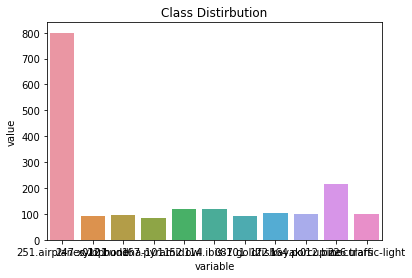

In [4]:
# Plot the Class distribution
sns.barplot( data = pd.DataFrame.from_dict([pair_name]).melt(), 
             x = "variable", y="value"
             ).set_title("Class Distirbution")

In [5]:
# Data Transformation
states = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tt = tt.Compose([tt.ToTensor(), tt.RandomHorizontalFlip(), 
                       tt.Resize((64,64)), tt.Normalize(*states)])

test_tt = tt.Compose([tt.ToTensor(), 
                       tt.Resize((64,64)), tt.Normalize(*states)])

In [6]:
data_path = "/content/caltech256/256_ObjectCategories" 
batch_size = 512

dataset = torchvision.datasets.ImageFolder(data_path, transform= train_tt)

train_size = int( 0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size = batch_size,
                                           num_workers=2,
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size= 2*batch_size)

In [7]:
def show_image(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([]);
        ax.imshow( make_grid(images[:64], nrow=8).permute(1,2,0))
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


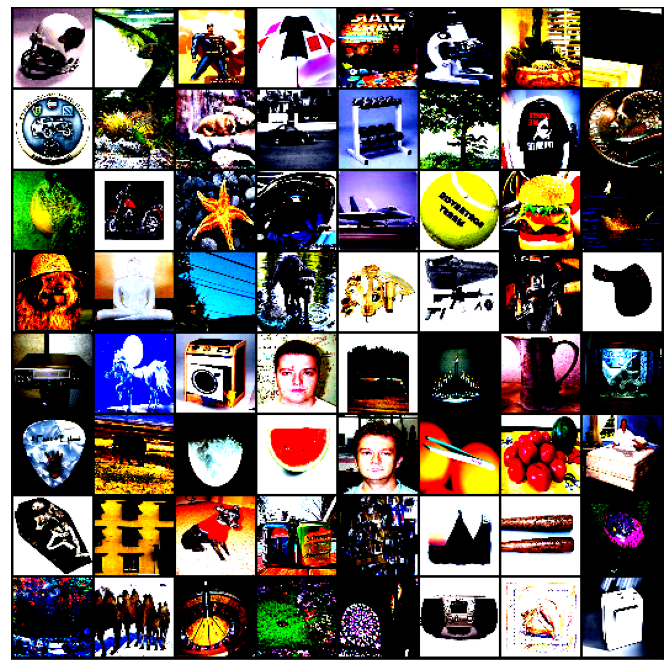

In [8]:
show_image(train_loader)

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [ to_device(x, device) for x in data]
    else:
        return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [10]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [11]:
for img, label in train_loader:
    print(img.device)
    break

cuda:0


In [12]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs,labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [ x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [ x["val_acc"] for x in outputs]
        epoch_acc  = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
    

In [13]:
def conv_block(in_channel,  out_channel, pool= False):
    layers =  [ nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channel),
                nn.LeakyReLU(0.2) ]
    if pool: layers.append(nn.AvgPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = conv_block(in_size, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1  = nn.Sequential( conv_block(128, 128), conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2  = nn.Sequential( conv_block(512, 512), conv_block(512, 512))
        self.classifier = nn.Sequential( nn.AvgPool2d(8),
                                         nn.Flatten(),
                                        #  nn.Dropout(0.2),
                                         nn.Linear(512, out_size))
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)  +  out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)  +  out
        out = self.classifier(out)
        return out
        


In [14]:
model = to_device(ResNet9(3, 257), device)

In [15]:
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(n

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [ model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD ):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay= weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch =len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            train_loss.append(loss)
            lrs.append(get_lr(optimizer))

            sched.step()
        
        # validation Step
        result = evaluate(model, val_loader)
        result['lr'] = lrs 
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [17]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.0071900468319654465, 'val_loss': 5.547784328460693}]

In [18]:
epochs = 40
weight_decay = 1e-4
max_lr = 0.01
grad_clip = 0.1
opt_func = torch.optim.Adam

In [ ]:
history += fit(epochs, max_lr, model, train_loader, val_loader,
               weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)